In [7]:
#!/usr/bin/env python3

############################################
'''This is a LinkedIn job scraping program.
Requres a LinkedIn search URL and the approx. 
number of postings returned. It returns a 
text/table file with values that's compatable 
with R and Python. This code's purpose is 
intended to be used for an example project. 
Only run this code to make a new scrape it 
will change the answers below. A back-up copy
of the original text file is: scraped_table-Docker.txt'''
############################################


###################
## Global imports##
###################
import re
import math
import requests
from bs4 import BeautifulSoup
from collections import defaultdict

####################
##Global Variables##
####################


################
##Input files##
################

##Target URL##
'''URL that has the search results'''
'''Identified from Dev tools > Fetch > Identify "Search" URL after scrolling down with infinite scroll.'''
target_url = "https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords=Data%2BAnalysis&location=Oregon%2C%2BUnited%2BStates&geoId=101685541&f_TPR=r2592000&original_referer=https%3A%2F%2Fwww.linkedin.com%2Fjobs%2Fsearch%3Fkeywords%3DData%2520Analysis%26location%3DOregon%26geoId%3D%26trk%3Dpublic_jobs_jobs-search-bar_search-submit%26position%3D1%26pageNum%3D0&start={}"

##Post Number##
'''Number of job postings from the search'''
post_num = 7000

##Post URL##
'''URL for the individual job posting'''
post_url = "https://www.linkedin.com/jobs-guest/jobs/api/jobPosting/{}"

################
##Output files##
################

##Out table##
'''Initiates a txt tab deliminated file'''
scraped_table = "./scraped_table.txt"
out_file = open(scraped_table, "w")


###########
##Classes##
###########
'''This class gets all the job posting ids when given a LinkedIn job search URL'''
class get_job_ids:
    
    '''Object constructor'''
    def __init__(self, num_results, target_url):
        ##Class variables##
        self.num_results = num_results
        self.target_url = target_url
    
    
    '''Gets all of the job IDs'''
    def get_ids(self):
        all_HTML =[]
        
        '''Takes the number of results and devides it by 25 results per page'''
        for page in range(0, math.ceil(self.num_results/25)):
            '''The get() method sends a GET request to the specified url and creates a RESPONSE object'''
            url_results = requests.get(self.target_url.format(page))
            '''Fetches the raw HTML content from the URL'''
            HTML = BeautifulSoup(url_results.text,'html.parser')
            '''Because each new request returns a new/differnt set of job postings. The postings 
            HTML will be added to a list, which will prevent new/different requesting information 
            from being used later in the code'''
            all_HTML.append(HTML)
        
        '''Returning only the job IDs'''
        jobs = list(set([w.replace("jobPosting:", "") for w in re.findall(r'jobPosting:[0-9]+', str((all_HTML)))]))
        return jobs

'''This class scrapes for the following: Job Title, job desires a Batchlor's and/or Master's degree
desired years of experience from the HTML code'''
class scrapped_info:
    
    '''Object constructor'''
    def __init__(self, post_url, job_ids):
        ##Class variables##
        self.post_url = post_url
        self.job_ids = job_ids
        
    '''Gets the raw HTML per job posting id'''
    def get_html(self, job_id):
        job_post_request = requests.get(post_url.format(job_id))
        job_HTML=BeautifulSoup(job_post_request.text,'html.parser')
        return job_id, job_HTML
    
    
    '''Creates two dictionarys in the same order that will be used to scrap and store scaped job
    information. Removes job ids that are not associated with the terms data and analyst'''
    def get_scrapper_dicts(self):
        job_dict = defaultdict(list)
        html_dict = {}
        
        for job_id in range(0,len(self.job_ids)):
            job_HTML = str(self.get_html(self.job_ids[job_id])[1])
            job_title = re.findall(r'mb-0 topcard__title">(.+)</h2>', job_HTML)
            
            while len(job_title) == 0:
                job_HTML = str(self.get_html(self.job_ids[job_id])[1])
                job_title = re.findall(r'mb-0 topcard__title">(.+)</h2>', job_HTML)
            else:
                if "data" in "".join(job_title).lower() or "analyst" in "".join(job_title).lower():
                    job_dict[self.job_ids[job_id]].append("".join(job_title))
                    html_dict[self.job_ids[job_id]] = job_HTML
                        
        return job_dict, html_dict
    
    '''Identified if a job posting desires a bachelers or masters degree'''
    def desired_degrees(self):
        job_dict, html_dict = self.get_scrapper_dicts()
        for filt_id, filt_HTML in html_dict.items():
            b_degree = re.findall(r'(Bachelor|bachelor)', filt_HTML)
            m_degree = re.findall(r'(Master|master)', filt_HTML)
            
            if len(b_degree) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")
            
            if len(m_degree) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")
        
        return job_dict, html_dict
        
    '''Identified if a job posting desires year of experience (YOE)'''
    def years_of_expereince(self):
        
        job_dict, html_dict = self.desired_degrees()
        for filt_id, filt_HTML in html_dict.items():
        ##Will need to include wider case scinarios when I come accross them.
        ##Can handel 2 digits and one to five spelled out. 
            YOE = re.findall(r'(\d{1,2}|one|two|three|four|five)(?:\s|-|\)|\+|-[0-9]+| or fewer)(?:\s|)(?:years|years|year).+', filt_HTML)
            if len(YOE) == 0:
                job_dict[filt_id].append(0)
            else:
                job_dict[filt_id].append("".join(YOE))
        
        return job_dict, html_dict 
    
    '''Identified if a job posting desires skills such as SQL, Excel, Power BI, Tableau, Python, or R'''
    def desired_skills(self):
        job_dict, html_dict = self.years_of_expereince()
        for filt_id, filt_HTML in html_dict.items():
            SQL = re.findall(r'(?:SQL|sql)', filt_HTML)
            excel = re.findall(r'(?:excel|Excel)', filt_HTML)
            powerBI = re.findall(r'(?:PowerBI|Powerbi|Power BI|Power bi|power BI|power bi|powerbi|powerBI)', filt_HTML)
            tableau = re.findall(r'(?:tableau|Tableau)', filt_HTML)
            python = re.findall(r'(?:Python|python)', filt_HTML)
            R = re.findall(r'(?:\sR\s)', filt_HTML)
            if len(SQL) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")
                
            if len(excel) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")
                
            if len(powerBI) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")
                
            if len(tableau) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")           
            
            if len(python) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")   

            if len(R) == 0:
                job_dict[filt_id].append("No")
            else:
                job_dict[filt_id].append("Yes")   
                
            
        return job_dict, html_dict 
        
    
########
##Body##    
########        

'''Starting point of execution of code. Explaination at main() function:
https://www.mygreatlearning.com/blog/python-main/ This code has the 
possibility to use stand alone classes and functions. For this example 
purpose,all are utilized.'''
def main():
    
    '''Creates a class object and provides the class and functions the initinal input'''
    class_get_job_ids = get_job_ids(post_num, target_url)
    job_ids = class_get_job_ids.get_ids()
    
    '''Creates a class object and provides the class and functions the initinal input'''
    class_scapper_info = scrapped_info(post_url, job_ids)
    job_dict, html_dict = class_scapper_info.desired_skills()

    '''Outputs the scraped information into table that is tab delimited'''
    out_file.write(f'Posting ID\tTitle\tDesires Bachelor\'s\tDesires Masters\'s\tYears of Experience\t\SQL Skills\tExcel Skills\tPower BI Skills\tTableau Skills\tPython Skills\tR Skills\n')
    for scraped_id,scraped_info in job_dict.items():
    
        out_file.write(f'{scraped_id}\t{scraped_info[0]}\t{scraped_info[1]}\t{scraped_info[2]}\t{scraped_info[3]}\t{scraped_info[4]}\t{scraped_info[5]}\t{scraped_info[6]}\t{scraped_info[7]}\t{scraped_info[8]}\t{scraped_info[9]}\n')
    
    out_file.close()
    
   

if __name__ == "__main__":
    main()


In [8]:
#########################################################
'''We outputted the above scraped data into a table (TSV)
to use later on, yet we could have put the data directly
into a Postgre SQL table or into pandas dataframe. It is 
also possible to take Postgres QSL tables and convert them
to pandas dataframes. We will do both showing the 
possibilities In order to put our data into a PostgreSQL 
table, we first need to create a database.'''
#########################################################


###################
## Global imports##
###################

import psycopg2


########
##Body##    
########  
def main():

    '''Establishes connection'''
    try:
        conn = psycopg2.connect(
           database = "postgres", 
            user ='postgres', 
            host ='db', 
            port = '5432',
            password = 'postgres'
        )
    except (Exception, psycopg2.Error) as error :
        print ("Error while connecting to PostgreSQL", error)

    '''Individual statements are committed implicitly'''
    conn.autocommit = True

    '''Creates cursor object'''
    cursor = conn.cursor()

    '''Creates query object'''
    sql = '''CREATE database projects''';

    '''Creates database'''
    try:
        cursor.execute(sql)
        print("Database created successfully........")

    except (Exception, psycopg2.Error) as error :
        print ("Database \"projects\" already exists")


    '''Closes connection'''
    conn.close()
if __name__ == "__main__":
    main()


Database "projects" already exists


In [9]:
#########################################################
'''Next, we will take our TSV data and put it into a 
Postgres QSL table. Then we will take our Postgres QSL 
table and put it into a pandas dataframe. This will show
that it is possible to have data go either way for 
conversion cases.'''
#########################################################

###################
## Global imports##
###################
import sys
import psycopg2 
import pandas as pd 
from sqlalchemy import create_engine,text 


#############
##Functions##
#############

'''Each container will have an IP Address. 
You will need to get this! Insructions are in README.
Example: IP_Address = '172.18.0.2'
'''

IP_Address = '<YOUR IP ADDRESS>'

def make_sql():
    try: 
        '''Turning our TSV table into a PostgreSQL table.'''   
        conn_string = f'postgresql://postgres:postgres@{IP_Address}:5432/postgres'
        conn_db = create_engine(conn_string) 
        conn1 = conn_db.connect()
        conn1.autocommit = True
        job_df = pd.read_csv('./scraped_table.txt', sep='\t')
        job_df.to_sql('linkedin_job_scrape', conn1, if_exists = 'replace') 
        conn1.close()
        return "Table Created Successfully"
    except:
        return "Error While Creating Table"


def make_pd_df():
    try:
        '''Turning our PostgreSQL table into a Pandas dataframe.'''
        conn_string = f'postgresql://postgres:postgres@{IP_Address}:5432/postgres'
        conn_db = create_engine(conn_string)
        conn2 = conn_db.connect()
        query = '''SELECT * FROM linkedin_job_scrape'''
        df = pd.DataFrame(conn2.execute(text(query)))
        conn2.close()
        return df
    except:
        return print("Error Creating Table", sys.stderr) 


########
##Body##    
######## 
def main():
    df = make_pd_df()
    print("\033[1mHere are the first 10 rows for our successfully created dataframe:\033[0m\n",df.iloc[0:10,:])
    
if __name__ == "__main__":
    main()





Here are the first 10 rows for our successfully created dataframe:
    index  Posting ID                             Title Desires Bachelor's  \
0      0  3969047428             SAP Reporting Analyst                 No   
1      1  3954426259                      Data Analyst                Yes   
2      2  3972945326  Management &amp; Program Analyst                Yes   
3      3  3965839321                  Business Analyst                 No   
4      4  3967877062                 Financial Analyst                Yes   
5      5  3969553311  Healthcare Data Analyst *Remote*                Yes   
6      6  3973492656   Department Head of Data Science                 No   
7      7  3967410806           Data Governance Analyst                Yes   
8      8  3971193590       Business Systems Analyst II                 No   
9      9  3955838911      Data &amp; Applied Scientist                Yes   

  Desires Masters's Years of Experience     SQL Skills Excel Skills  \
0            

In [55]:
#########################################################
'''Now that we know how to format our data to put into 
differnt programs, lets actually start to manipulate our 
data to see what information we can learn from it. A good 
first start to any data analysis is to take a peak at the 
data to see what it looks like and to see if there is any 
cleaning that we need to do. '''
#########################################################

###################
## Global imports##
###################


import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


########
##Body##
########

'''If you run this code it will allow you to run the code on a new 
HTML job posting scrape. This WILL change the RESULTS and cause 
analysis answers in the text to be incorrect! This is because each
job search returns different/new results. 
'''
#df = make_pd_df()

'''It is recommend to run the supplied text. It will refelct the 
correct answers in the text for the analysis.'''
df = pd.read_csv('./scraped_table-Docker.txt', sep='\t')


'''Lets first get the dimentions of our dataframe'''
print(f"\033[1mHere are the dataframe dimentions:\033[0m",df.shape)
'''We were able to get 164 job ids from our scrape!'''


'''Lets look at the first 20 rows from all the columns of our dataframe'''
print(f"\033[1mHere are the first 20 rows of the dataframe:\033[0m\n",df.iloc[0:10,3:12])

'''From out data, we can see that we have one discrete variable/column, and 
eight categorical variables/columns. Let's see what are the values of our 
data are with value_counts method.'''
print(f"\033[1mHere are the counts:\033[0m\n",[df[col].value_counts() for col in df.iloc[:,3:12]])

'''Our categorical data looks good, yet our discrete data needs some 
cleaning. We will need to convert written numbers to actual integers. 
Lets look at our data in a list to better see if there is any 
whitespace and our data types.'''
print(f"\033[1mBefore Formatting:\033[0m",df["Years of Experience"].tolist())

'''In addition to needing to convert written numbers to actual integers. 
The list view revealed that we will need to remove whitespaces and convert 
our numbers from strings to intigers. Frist lets start by replacing the 
written numbers with thier associated integers'''
replace_dict = {'one':1, 'two':2, 'three':3, 'four':4, 'five':5}
df["Years of Experience"] = df["Years of Experience"].replace(replace_dict)

'''Now we need to get rid of none values and whitespace .'''
YOE_l = df["Years of Experience"].tolist()
no_none_YOE = [0 if i == None else i for i in YOE_l]
nospace_YOE = [int(i) if str(i).isdigit() else i.replace(" ","") for i in no_none_YOE]

df["Years of Experience"] = nospace_YOE  

print(f"\033[1mAfter Formatting:\033[0m",df["Years of Experience"].tolist())  


Here are the dataframe dimentions: (199, 11)
Here are the first 20 rows of the dataframe:
   Desires Masters's Years of Experience \SQL Skills Excel Skills  \
0               Yes                   3          No          Yes   
1                No                 two          No          Yes   
2                No               three          No          Yes   
3                No                   0          No          Yes   
4               Yes                   0         Yes          Yes   
5                No                   1         Yes           No   
6                No                   1          No           No   
7                No                   1         Yes          Yes   
8                No                   0          No           No   
9                No                   1         Yes           No   

  Power BI Skills Tableau Skills Python Skills R Skills  
0              No             No            No       No  
1              No             No           Y

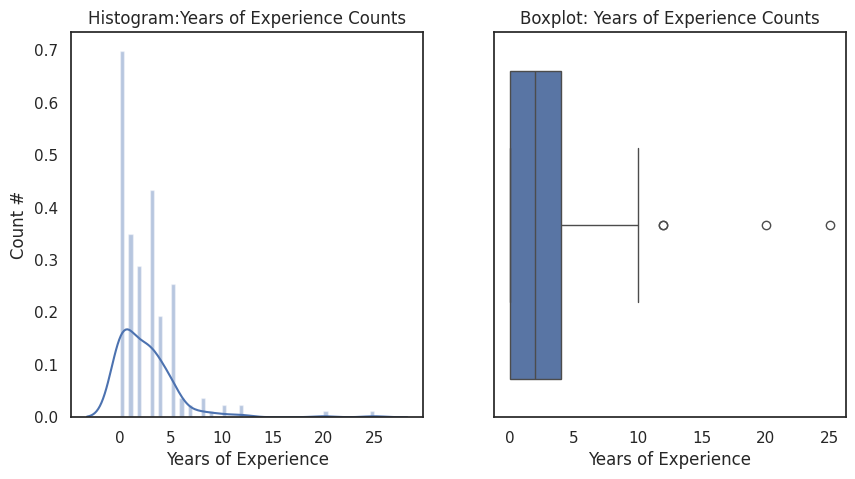

In [56]:
import warnings
warnings.filterwarnings('ignore')


'''We can finally plot our discrete data. Two good plots to start with are
a histogram and a boxplot.'''
nbins=60
fig, ax =plt.subplots(1,2, figsize=(10, 5))
sns.distplot(df["Years of Experience"], ax=ax[0], hist=True,bins=nbins)
sns.boxplot(df["Years of Experience"], ax=ax[1], orient="h")
sns.set_theme(style='white')
ax[0].set_ylabel("Count #")
ax[0].title.set_text('Histogram:Years of Experience Counts')
ax[1].title.set_text('Boxplot: Years of Experience Counts')
fig.show()
    


In [57]:
'''From our graphs, we can see some extreme values, 
yet they dont seem to be outliers. Summary statistics 
would be a good next step.'''
print(f"\033[1mSummart Stats:\033[0m\n",pd.Series(df["Years of Experience"]).describe())


'''What can we take away so far from our data? The mean is 2.5527, 
yet we have some high values in our data set as shown best by our 
boxplot and the histogram. Also, The data is right skewed. Sicne 
our data is right skewed with higher values, a median would be better 
to use because our mean is affected by the higher values. The median 
is 2.0, telling us most employeers are wanting two years of experience 
in a data analysis related field, yet some dont want any work experience (min)
and some want as much as 25 years (max) with most employers wanting zero to four 
years (25% and 75% percentiles), respectively.
'''

'''The next thing we need to do is to look at our categorical 
data. To do this, we first need to combine our categorical data 
into one dataframe to make it easier for us to make inferences 
and for graphing.'''
categorical_df = pd.concat([df.iloc[:, 2:4], df.iloc[:, 5:12]], axis=1).reindex(df.iloc[:, 3:5].index)

'''Formatting whitespace'''
requirement = [i.strip() for i in categorical_df.columns.tolist()]

'''Creating lists of counts for binary data (yes, no) and percents of each binary.'''
no_l = [categorical_df[col].value_counts()[0] for col in categorical_df]
yes_l = [categorical_df[col].value_counts()[1] for col in categorical_df]
percent_no = [no/len(categorical_df) for no in no_l]
percent_yes = [yes/len(categorical_df) for yes in yes_l]

'''Creating dataframe for graphing and viewing percentages'''
data_dict = {"requirement": requirement,
       "no": no_l,
       "yes": yes_l,
        "percent_no": percent_no,
        "percent_yes": percent_yes}

data_df = pd.DataFrame(data_dict)
print(f"\033[1mHere is the percentages dataframe:\033[0m\n",data_df)



Summart Stats:
 count    199.000000
mean       2.552764
std        3.118207
min        0.000000
25%        0.000000
50%        2.000000
75%        4.000000
max       25.000000
Name: Years of Experience, dtype: float64
Here is the percentages dataframe:
           requirement   no  yes  percent_no  percent_yes
0  Desires Bachelor's  102   97    0.512563     0.487437
1   Desires Masters's  158   41    0.793970     0.206030
2         \SQL Skills  145   54    0.728643     0.271357
3        Excel Skills  108   91    0.542714     0.457286
4     Power BI Skills  176   23    0.884422     0.115578
5      Tableau Skills  172   27    0.864322     0.135678
6       Python Skills  151   48    0.758794     0.241206
7            R Skills  188   11    0.944724     0.055276


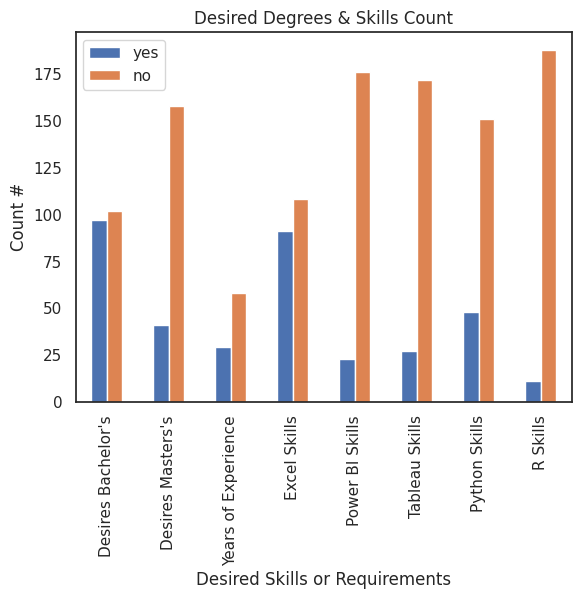

In [24]:
'''As above, a next good step would be to plot our data. Since 
our data is categorical a bar graph should be sufficient. Let's
plot eaching skill or requiement'''
bar = data_df.plot(x="requirement", y=["yes", "no"], kind="bar") 
plt.rcParams["figure.facecolor"] = "w"
bar.set_ylabel('Count #')
bar.set_xlabel('Desired Skills or Requirements')
bar.title.set_text('Desired Degrees & Skills Count')
plt.show()



In [28]:
'''What does our data tell us? From the bar graph and percentages of 
"yes" and "no", we can see that approx. 49% of data analyst 
related jobs want applicants to have a bachelor's degree. Approximatly, 
21% of jobs desire a master's. Interestingly, approx. only 27% of jobs 
want SQL experience, yet roughly 46% want Excel experience. The thrid
most desired skill was having Python coding expereince at ~24%, and even
lesser so for Tableau (14%), Power BI (12%), and R (6%). This tells us that
a bachelor's degree is the most desired degree and Excel is the most saught
after skill. Yet, this is not the end of the story! Let's explore 
a little more to see if this is backed with statistics!'''


'''Let's take a looks to see which companies desire a batchlor's or master's 
degree with thier associated years of experience (YOE).'''



titles = df[["Title", "Years of Experience"]][(categorical_df[["Desires Bachelor's", "Desires Masters's"]] == 'Yes').any(1)]
print(f"\033[1mHere is a glance at the types of companies that desire a degree:\033[0m\n",titles)





Here is a glance at the types of companies that desire a degree:
                                                  Title  Years of Experience
0    OR - Analyst- Revenue Integrity, Days+Remote W...                    3
1                                     Planning Analyst                    2
3        Wire Transfer Fraud Analyst and Investigation                    0
4                                Data Analyst Portland                    0
7                                      Data BI Analyst                    1
..                                                 ...                  ...
190              Vice President of Technology and Data                   12
192   Sr. Analyst, Geolocation Investigations (Remote)                    4
194                                  Actuarial Analyst                    5
195  Data Scientist (Senior Customer Experience Dat...                    1
198                                            Analyst                    1

[112 rows x 2 columns

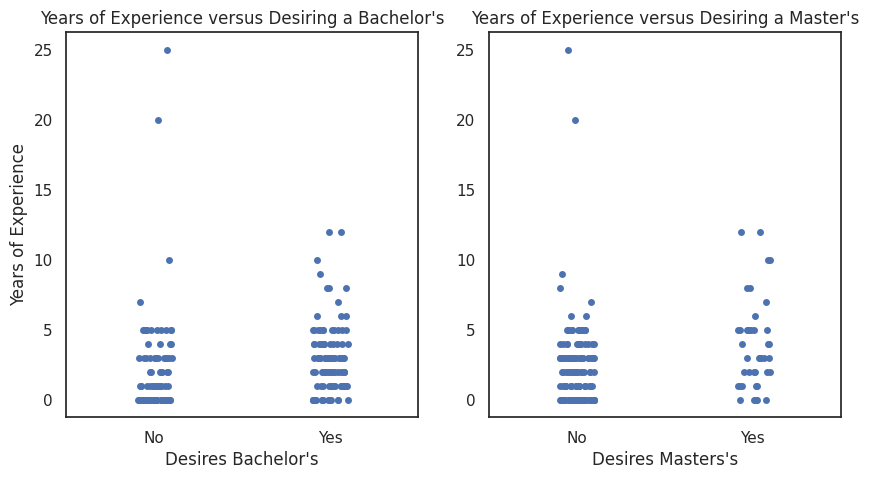

In [75]:
'''This showed us that 87 companies out of our 164 job postings want a degree, 
let's do some stats to see if there is a relationship between comanies wanting 
(YOE) and desiring a degree''' 

'''First let's look at scatter plots between YOE and desiring a bachelor's or 
master's degree to see if we can see any trends.'''
fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.stripplot(x = "Desires Bachelor's", y = "Years of Experience", data=df,ax=ax[0])
sns.stripplot(x = "Desires Masters's", y = "Years of Experience", data=df, ax=ax[1], order = ['No', 'Yes'])
sns.set_theme(style='white')
ax[1].set_ylabel("")
ax[0].title.set_text("Years of Experience versus Desiring a Bachelor's")
ax[1].title.set_text("Years of Experience versus Desiring a Master's")
fig.show()



In [98]:
'''We can see some interesting features from our scatter plots. 
1. Companies that don't require a degree have the higher amounts of experience.
2. Companies that want a degree want 12 YOE or less
'''

'''Next, let's check for independance between having a degree 
and a company's desire for YOE. A good question to ask with our data is,
"Do job postings that desire a degree versus a job postings that 
don't desire a degree have more often YOE required?" We can semi-answer 
this question first by checking for indepence with a chi-square test. 
This can be done by turning the YOE into a categorial variable and 
creating a 2 x 2 table.'''

###################
## Global imports##
###################

from scipy.stats import chi2_contingency

########
##Body##
########

'''Adding two new column to our dataframe that has YOE as yes (>0) or no (=0), and 
combines if the job post desires a bachelor's or master's.'''
cat_yoe = ["No" if year == 0 else "Yes" for year in df['Years of Experience'].tolist()]
cat_degree =[ "No" if deg == False else "Yes" for deg in (categorical_df[["Desires Bachelor's", "Desires Masters's"]] == 'Yes').any(1).tolist()]

df["cat_degree"] = cat_degree
df["cat_yoe"] = cat_yoe
print(f'\033[1mDataframe with New Categorical Variables Added:\033[0m\n',df.iloc[0:10,0:14])

'''Creating a 2 x 2 contingency table for our chi square test.'''
crosstab = pd.crosstab(df["cat_degree"], df["cat_yoe"]).reindex(["Yes", "No"],axis="columns").reindex(["Yes", "No"],axis="rows")


'''Performing a two-sided chi-square test.'''
chi2, p, dof, ex = chi2_contingency(crosstab)
print(f'\033[1mChi-square Test:\033[0m\n\033[1mTest Statistic:\033[0m {chi2}\n\033[1mp-value:\033[0m {p}\n\033[1mdof:\033[0m {dof}\n\033[1mexpected_freq:\033[0m\n{ex}\n')


'''Form the test, it produced a p-value of 1.915154808171304e-06, which 
is less than the significance level of 0.05. This would tell us that having
a degree is not equivalent as not having a degree with YOE, yet we can't make 
any claims if having a degree more often requires YEO then not having a degree. 
That's because the chi-square test performs a two-sided test and can't indicate 
the direction of the effect on the alternative hypothesis. We will need to do 
another test using odds ratio to support our observation that job postings 
desiring a degree require more often YOE versus job that don't require a degree.'''

'''Odds ratio test'''
from scipy.stats.contingency import odds_ratio
res = odds_ratio(crosstab)
print(f'\033[1mOdds Ratio Test:\033[0m\n',res.statistic)
print(f'\033[1mConfidence Interval:\033[0m\n',res.confidence_interval(confidence_level=0.95))

'''What does the odds ratio test tell us? It tells us that the odds 
of a job posting desiring a degree and requiring YOE is 4.93694812981915
times more often than a job posting that doesn't requie a degree.
The confidence interval for the odds ratio is:(low=2.44444872228293, 
high=10.334098784018948). Since the confidence interval does not include 
the number 1, the results would be considered significant.This would 
indicate that the odds of a job requiring YOE with a degree is greater 
then jobs not requiring a degree.'''

Dataframe with New Categorical Variables Added:
    Posting ID                                              Title  \
0  3962174045  OR - Analyst- Revenue Integrity, Days+Remote W...   
1  3970424858                                   Planning Analyst   
2  3973061907                    Department Head of Data Science   
3  3975495942      Wire Transfer Fraud Analyst and Investigation   
4  3972651403                              Data Analyst Portland   
5  3975526227                       Satistician (Data Scientist)   
6  3978564874  Management &amp; Program Analyst (Project Mana...   
7  3979102448                                    Data BI Analyst   
8  3965839321                                   Business Analyst   
9  3975521699                       Satistician (Data Scientist)   

  Desires Bachelor's Desires Masters's  Years of Experience \SQL Skills  \
0                 No               Yes                    3          No   
1                Yes                No              

In [100]:
'''We can dive even deeper and ask if there is independance
between having a degree and companies desiring over twelve YOE, 
as we saw in the scatter plots.'''

###################
## Global imports##
###################

import statsmodels.api as sm 
import numpy as np

########
##Body##
########

'''Adding a new column to our dataframe that has YOE as yes (>12) or no (<=12).'''
cat_12_yoe = ["No" if year <= 12 else "Yes" for year in df['Years of Experience'].tolist()]
df["cat_12_yoe"] = cat_12_yoe
print(f'\033[1mDataframe with New Categorical Variable Added:\033[0m\n',df.iloc[0:10,0:15])

'''Lets look at the counts of our data to see what we have.'''
print(f'\033[1mData counts for YOE as yes (>12) or no (<=12):\033[0m\n',df["cat_12_yoe"].value_counts())

'''Because we have very little counts for some of our categories, we can 
sample our observations from our current distribution of 164 observations.
A good way to do this is sample with replacement, which is used in methods 
such as bootstrapping.'''
com_l = [f'{deg_i}_{cat_i}' for deg_i,cat_i in zip(df["cat_degree"].tolist(),df["cat_12_yoe"].tolist())]
df["combined"] = com_l

np.random.seed(2)    
sample = df["combined"].sample(n=1000, replace=True)
sample = [samp.split("_") for samp in sample]
sample_deg = [samp[0] for samp in sample]
sample_yoe = [samp[1] for samp in sample]

crosstab_12 = pd.crosstab(sample_deg, sample_yoe).reindex(["No", "Yes"],axis="columns").reindex(["Yes", "No"],axis="rows")

'''Performing a two-sided chi-square test.'''
chi2_12, p_12, dof_12, ex_12 = chi2_contingency(crosstab_12)
print(f'\033[1mChi-square Test:\033[0m\n\033[1mTest Statistic:\033[0m {chi2_12}\n\033[1mp-value:\033[0m {p_12}\n\033[1mdof:\033[0m {dof_12}\n\033[1mexpected_freq:\033[0m\n{ex_12}\n')


'''From the chi-square test, we get a p-value of 0.000959891215517953, which
again is less than the significance level of 0.05. This would indicate that having
a degree is not equivalent as not having a degree with requiring 12 YOE. Because
the chi-square test can't indicate the direction of the effect on the alternative 
hypothesis we will again perform another test "odds ratio" test to see if we can make
an inference.'''

'''Performing odds ratio test. Typically,since we have zeros in our table we will need to 
perform a Haldane-Anscombe correction by add 0.5 to each cell in our 2 x 2 table.'''
add = crosstab_12+0.5
np_tab = add.to_numpy()

table = sm.stats.Table2x2(np_tab, shift_zeros=False)
odds_ratio = table.oddsratio
confintab = table.oddsratio_confint()
print(f'\033[1mOdds Ratio Test:\033[0m\n', odds_ratio)
print(f'\033[1mConfidence Interval:\033[0m\n', confintab)

'''What does the test tell us? The odds of a job posting not desiring a degree 
and requiring  more than 12 YOE is 27.543840177580467 times more likely than a job
posting that does desire a degree. The confidence interval is (low=1.6186522322492631,
high=468.70051306441883), which is significan't because it doesn't include the number 1. 
This would indicates that the odds of a job requiring over 10 YOE without a degree 
is greater then jobs that desire a degree.'''

'''What is the big picture/take away from what we did? Form all the information we obtained, 
most jobs want a few basic skills depending upon thier needs with most wanting Excel and SQL
skills. About half of job posting are wanting a degress, the most common being a bachelor's
degree. And, most job require less than 10 years of experience. Jobs that don't require a 
degree could ask for more years of experience. 
'''

'''Over all pitfalls: 
1. Job posting search was only from Oregon area. Data maybe not be represtive of
national jobs postings. 
2. Job postings desires and skills change from day to day, resulting in results that become 
inaccurate quickly. 
3. Small sample categories observed, which could give less statistical power.
4. Sampling can cause bias for small sample sizes.
5. More/differnt statistical methods could have been implemented. 
'''




Dataframe with New Categorical Variable Added:
    Posting ID                                              Title  \
0  3962174045  OR - Analyst- Revenue Integrity, Days+Remote W...   
1  3970424858                                   Planning Analyst   
2  3973061907                    Department Head of Data Science   
3  3975495942      Wire Transfer Fraud Analyst and Investigation   
4  3972651403                              Data Analyst Portland   
5  3975526227                       Satistician (Data Scientist)   
6  3978564874  Management &amp; Program Analyst (Project Mana...   
7  3979102448                                    Data BI Analyst   
8  3965839321                                   Business Analyst   
9  3975521699                       Satistician (Data Scientist)   

  Desires Bachelor's Desires Masters's  Years of Experience \SQL Skills  \
0                 No               Yes                    3          No   
1                Yes                No               